# This code will train the model and save weights  using a data generator

First Import libraries

In [36]:
import os
import numpy as np
import keras
import tensorflow
from sklearn.model_selection import train_test_split
import nibabel as nib
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil

In [37]:
from tensorflow.python.client import device_lib
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Define our Data Generator and other functions to be used later

In [38]:
from Data_Gen import DataGenerator 

In [39]:
test_image = np.load(r"C:\Users\UAB\Kidney-Segmentation-Jupyter\data\KU_105005_0_84_L_50_M.npy")
test_label = np.load(r"C:\Users\UAB\Kidney-Segmentation-Jupyter\data\KU_105005_0_84_L_50_K.npy")

In [40]:
test_image.shape

(512, 512)

In [41]:
test_label.shape
test_label.max()

1.0

In [42]:
def gather_set(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(f)
      else:
        continue
    #set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

In [43]:
def gather_set_and_path(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(str(data_path+f))
      else:
        continue
    #set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

Define the paths where images and segmentations are located. Gather into groups and arrange into a dictionary that can be split up for training, testing, and validation for the model

## Expected Dimmentions

Image: (512,512) range: 0:255

Label: (512,512) range: 0:1

In [44]:
data_path_1 = r"C:\Users\UAB\Kidney-Segmentation-Jupyter\data\\"
data_path_2 = r"C:\Users\UAB\data\Mayo\data\\"
data_path_3 = r"C:\Users\UAB\data\Emory\data\\"
data_path_4 = r"C:\Users\UAB\data\UAB\data\\"

images_1 = gather_set_and_path(data_path_1, '_M')
images_2 = gather_set_and_path(data_path_2, '_M')
images_3 = gather_set_and_path(data_path_3, '_M')
images_4 = gather_set_and_path(data_path_4, '_M')


images = images_1+images_2+images_3+images_4

print(len(images))



67354


In [45]:
print(len(images_1))
print(len(images_2))
print(len(images_3))
print(len(images_4))


26262
21037
18974
1081


C:\Users\UAB\data\Emory\data\\EM_295106_2_120_L_47_M.npy


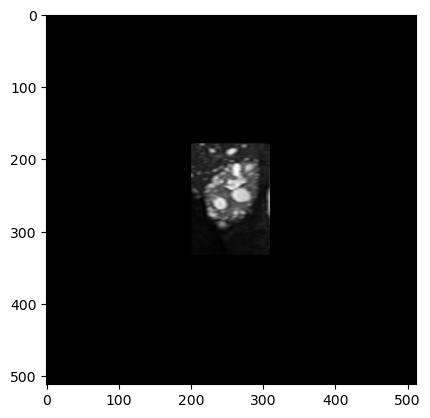

In [46]:
%matplotlib inline
print(images[-1500])
image = np.load(images[-1500])
plt.imshow(image, cmap='gray')
 


In [47]:
labels_1 = gather_set_and_path(data_path_1, '_K')
labels_2 = gather_set_and_path(data_path_2, '_K')
labels_3 = gather_set_and_path(data_path_3, '_K')
labels_4 = gather_set_and_path(data_path_4, '_K')

labels = labels_1 + labels_2 + labels_3 + labels_4
print(len(labels))


67354


In [48]:
test_img = np.load(images[100])
print(test_img.shape)
test_lab = np.load(labels[100])
print(test_lab.shape)


(512, 512)
(512, 512)


## Define Image and Label ID for data generator

Here the "test train split" will need to be replaced so we have the whole patient in one or the other"


In [30]:
#d = {}
#for i in images:
#    if i not in d:
#        d[i] = len(d)

#labels_mapping = list(map(d.get, images))
#print(labels_mapping)

#labels = {images[i]:labels_mapping[i] for i in range(len(images))}

Image separation for entire patient in training or validation - use with single set of images


In [12]:
#from sklearn.model_selection import train_test_split


#id_list = []   
#for i in range(len(images)):
#    image_name = images[i]
#    unique_id =  image_name[0:8]
#    id_list.append(unique_id)

#unique_ids = list(set(id_list))
#train, val = train_test_split(unique_ids, train_size = 0.8)

#train_list = [image for image in images if image[0:8] in train]
#val_list = [image for image in images if image[0:8] in val] 

#partition = {'train':train_list, 'validation':val_list}

## Use for crossfold validation:

In [49]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [88]:
train_sets = ['MA_', 'KU_', "UB_"]
val_sets = ["EM_"]

train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train_sets):
        train_list.append(images[i])


In [89]:
print(train_list[100])

C:\Users\UAB\Kidney-Segmentation-Jupyter\data\\KU_101934_1_96_R_13_M.npy


In [90]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val_sets):
        val_list.append(images[i])


In [91]:
print(val_list[100])

C:\Users\UAB\data\Emory\data\\EM_200922_0_144_L_60_M.npy


In [92]:
partition = {'train':train_list, 'validation':val_list}
print(len(train_list))
print(len(val_list))

48380
18974


Create our data generators 

In [93]:
params = {'dim': (512,512),
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': True}
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

In [94]:
X,y = training_generator[8]
print(X.shape, y.shape)

(32, 512, 512, 1) (32, 512, 512, 2)


## View output

(512, 512) 124.0 0.0


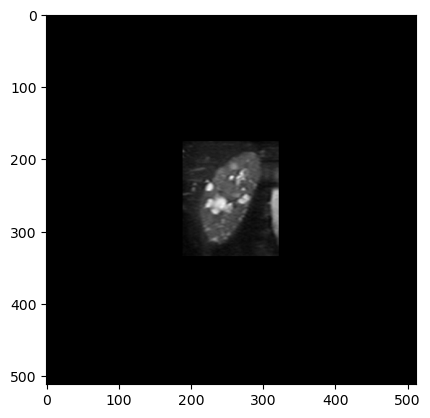

In [95]:
X_batch = X[20,:,:,:]
X_batch.shape
X_img = X_batch[:,:,0]
print(X_img.shape, X_img.max(), X_img.min())

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_img, cmap="gray")

(512, 512) 1.0 0.0


<Figure size 640x480 with 0 Axes>

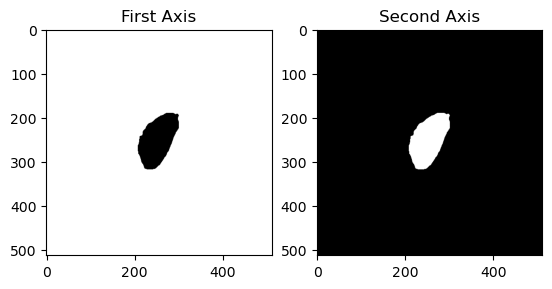

In [96]:
y_batch = y[20,:,:,:]
y_batch.shape
y_img_0 = y_batch[:,:,0]
y_img_1 = y_batch[:,:,1]
print(y_img_0.shape, y_img_0.max(), y_img_0.min())


plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(y_img_0, cmap="gray")
axarr[0].title.set_text('First Axis')
axarr[1].imshow(y_img_1, cmap='gray')
axarr[1].title.set_text('Second Axis')

In [97]:
X1, y1 = training_generator[20]
print(X1.shape)
print(y1.shape)

(32, 512, 512, 1)
(32, 512, 512, 2)


In [98]:
#params = {'dim': (512,512),
         # 'batch_size': 30,
         # 'n_classes': 2,
        #  'n_channels': 1,
        #  'shuffle': True}
#training_generator_2 = DataGenerator(partition['train'], labels, **params)
#validation_generator_2 = DataGenerator(partition['validation'], labels, **params)

In [99]:
model = custom_unet(input_shape=(512,512,1), num_classes=2)
#model.summary()

In [100]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint
filepath = "UNET_MA_KU_UB_train_EM_val.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [101]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
  loss=jaccard_distance,
  metrics=[dice_coef])

In [102]:
# Train model on dataset
history = model.fit(training_generator, epochs = 10,
                    validation_data = validation_generator,
                    use_multiprocessing=False,
                    workers=6, batch_size = 32)

Epoch 1/10
1511/1511 [==============================] - 695s 458ms/step - loss: 0.2828 - dice_coef: 0.8585 - val_loss: 0.0376 - val_dice_coef: 0.9809
Epoch 2/10
1511/1511 [==============================] - 694s 459ms/step - loss: 0.0224 - dice_coef: 0.9886 - val_loss: 0.0092 - val_dice_coef: 0.9953
Epoch 3/10
1511/1511 [==============================] - 693s 458ms/step - loss: 0.0093 - dice_coef: 0.9952 - val_loss: 0.0062 - val_dice_coef: 0.9969
Epoch 4/10
1511/1511 [==============================] - 692s 458ms/step - loss: 0.0068 - dice_coef: 0.9965 - val_loss: 0.0050 - val_dice_coef: 0.9974
Epoch 5/10
1511/1511 [==============================] - 692s 458ms/step - loss: 0.0058 - dice_coef: 0.9971 - val_loss: 0.0044 - val_dice_coef: 0.9978
Epoch 6/10
1511/1511 [==============================] - 693s 458ms/step - loss: 0.0051 - dice_coef: 0.9974 - val_loss: 0.0040 - val_dice_coef: 0.9980
Epoch 7/10
1511/1511 [==============================] - 692s 458ms/step - loss: 0.0047 - dice_coef: 

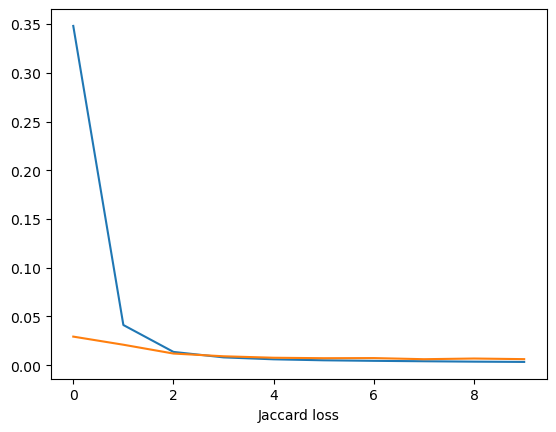

In [86]:
%matplotlib inline
plt.plot(range(len(history.history['loss'])), history.history['loss'], '-') #TODO: plot the training loss learning curve
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], '-') #TODO: plot the validation loss learning curve
plt.xlabel('epoch')
plt.xlabel('Jaccard loss')

plt.show()

Text(0.5, 0, 'Dice coefficient')

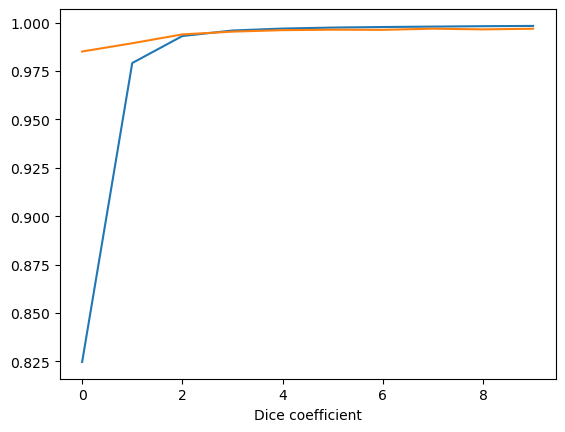

In [87]:
plt.plot(range(len(history.history['dice_coef'])), history.history['dice_coef'], '-') #TODO: plot the training dice_coef learning curve

plt.plot(range(len(history.history['val_dice_coef'])), history.history['val_dice_coef'], '-') #TODO: plot the validation dice_coef learning curve
plt.xlabel('epoch')
plt.xlabel('Dice coefficient')

In [85]:
from keras.models import Sequential, load_model
model.save( "UNET_MA_EM_UB_train_KU_val.h5")    